In [1]:
from sklearn.datasets import fetch_covtype # dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report

In [2]:
# download the dataset from:
# "http://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
cover_type = fetch_covtype() 

In [3]:
y = cover_type.target
X = cover_type.data

X.shape, y.shape

((581012, 54), (581012,))

###  Forest Covertype Dataset contains 581012 samples with  54 features. Explored in depth: 
https://github.com/adamszabunio/Forest_Cover_Type/tree/master/EDA/Further_EDA_and_Logistic_Regression.ipynb
### Since our dataset is rather large, and we will be doing cross validation on our training set,
- We set the test_size paramater to 0.1 set aside %10 to test the trained models accuracy.
- Due to large class imbalances in our target matrix, we set the stratify parameter=y. 
    - This makes a split so that the proportion of classes in the test and train sets will be similar

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=42, # for reproducibility
                                                    stratify=y)

In [5]:
X_train.shape, X_test.shape

((522910, 54), (58102, 54))

## Adaptive Boost Algorithm

In [ ]:
'''
Given: 
    N, (number of samples)
    estimators, (number of estimators)
    weakL, (weak learner)
    X_train, y_train (training set from data (X,y))

# Initialize weights
For each sample in range(N):
    weight = 1/N

For each est in range(estimators):
    # fit a weak learner to the training data using the weight 
    est = weakL.fit(X_train, y_train, weight)
    # calculate error
    error = sum(weight * (est(x) != y)) / sum(weight)
    # calculate alpha
    alpha = (1/2)ln((1-error)/error)
    # Update weights
    weight *= exp(alpha * (est(x) != y))
    
    For each i in range(N):
        # estimator misclassifies y
        if est(x_i) != y: 
            # increase weight of i for next estimator
            weight_i(est + 1) = weight_i(est)/(2*error)
        # estimator classifies y correctly
        else:
            # decrease weight of i for next estimator
            weight_i(est + 1) = weight_i(est)/(2*(1-error))
            
# return sum of predictions for all est*alpha
return sum(est*alpha)
'''

### Reasons to use Ada Boost
- Besides deciding on the number of weak classifiers (assumption is made) and the initial weight, there are no parameters to tune
- Fast and versatile 
- You can have little prior knowledge about the weak classifier (for example, decision stumps)

In [6]:
clf_stump = AdaBoostClassifier()
clf_stump.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

### Default "base_estimator" for AdaBoost Classifier is a Decision Tree with max_depth=1 (aka "Decision Stump")

In [7]:
clf_stump.score(X_test, y_test) 

0.4541668100925958

### Score is slightly worse than the handcoded [RandomForest class](https://github.com/adamszabunio/Forest_Cover_Type/tree/master/Random_Forests/random_forests.py) implemented in [this notebook](https://github.com/adamszabunio/Forest_Cover_Type/tree/master/Random_Forests/Random_Forests_on_Random_Forests.ipynb)

In [8]:
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=10, random_state=None)

In [9]:
# the default for AdaBoost Classifier is a Decision Stump with max_depth=1
# when we take this default away, the decision tree continues splitting at each node until
# it reaches purity, no surprise the model with an perfectly fit tree preforms better 
clf.score(X_test, y_test)

0.94125847647241057

### However, if we change the base estimator to a DecisionTreeClassifier() with no restriction on max_depth (with an equal number of estimators, 10)
- compared to the default AdaBoostClassifier, the score nearly doubles.
- compared to the handcoded implementation of RandomForests not only does the score double, the runtime is oreders of magnitude faster.

In [10]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.94      0.94      0.94     21184
          2       0.95      0.95      0.95     28331
          3       0.93      0.93      0.93      3575
          4       0.84      0.82      0.83       275
          5       0.84      0.84      0.84       949
          6       0.88      0.87      0.87      1737
          7       0.95      0.94      0.94      2051

avg / total       0.94      0.94      0.94     58102



# Time comparisons between training RandomForestClassifier and AdaBoost Classifier

In [11]:
%%timeit 
clf_rf = RandomForestClassifier()# 10 trees
clf_rf.fit(X_train, y_train)

1 loop, best of 3: 20.6 s per loop


In [13]:
%%timeit 
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10)
clf.fit(X_train, y_train)

1 loop, best of 3: 14.6 s per loop


In [14]:
clf_rf = RandomForestClassifier()# 10 trees
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Time comparisons between predictions for RandomForestClassifier and AdaBoost Classifier

In [16]:
%%timeit -n 10
clf.score(X_test, y_test)

10 loops, best of 3: 43.9 ms per loop


In [17]:
%%timeit -n 10
clf_rf.score(X_test, y_test)

10 loops, best of 3: 269 ms per loop


In [20]:
clf_rf.score(X_test, y_test)

0.94624969880554888

In [21]:
import pandas as pd
pd.DataFrame({"training runtime": ["20.6 s", "14.6 s"], \
              "predicition runtime": ["269 ms","43.9 ms"], \
              "score": [0.9462, 0.9413]}, \
              index=["RandomForestClassifier", "AdaBoost Classifier"])

,predicition runtime,score,training runtime
RandomForestClassifier,269 ms,0.9462,20.6 s
AdaBoost Classifier,43.9 ms,0.9413,14.6 s


# Conclusion:
### Similar scores for both algorithims 
- AdaBoost is faster for trainging (albeit a high learning rate of 1.0)
- AdaBoost is much faster at prediciting (nearly an order of magnitude)

___

### Save comparison table

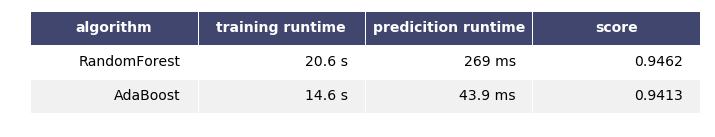

In [9]:
'''https://stackoverflow.com/a/39358722'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import six
%matplotlib inline

df = pd.DataFrame()
df["algorithm"] = ["RandomForest", "AdaBoost"]
df["training runtime"] = ["20.6 s", "14.6 s"]
df["predicition runtime"] = ["269 ms","43.9 ms"]
df["score"] = [0.9462, 0.9413]

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

ax = render_mpl_table(df, header_columns=0, col_width=3);

In [11]:
fig = ax.get_figure()

fig.savefig("algo_time_score_comparison.png")

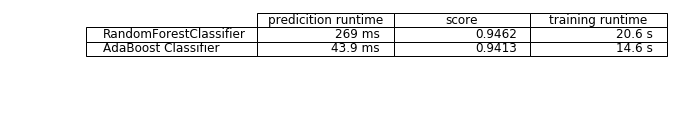

In [14]:
'''https://stackoverflow.com/a/36904120'''
from pandas.plotting import table

df = pd.DataFrame({"training runtime": ["20.6 s", "14.6 s"], \
              "predicition runtime": ["269 ms","43.9 ms"], \
              "score": [0.9462, 0.9413]}, \
              index=["RandomForestClassifier", "AdaBoost Classifier"])

fig, ax = plt.subplots(figsize=(12, 2)) # set size frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis
ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
tabla.auto_set_font_size(False) # Activate set fontsize manually
tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
tabla.scale(1.2, 1.2) # change size table
plt.savefig('table.png', transparent=True)

___